In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('df_dummies.csv')

In [3]:
df= df.drop(columns=['Unnamed: 0'], axis=1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168018 entries, 0 to 168017
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   Month       168018 non-null  int64
 1   DayofMonth  168018 non-null  int64
 2   ArrTime     168018 non-null  int64
 3   DepDelay    168018 non-null  int64
 4   Distance    168018 non-null  int64
 5   DayofWeek   168018 non-null  int64
 6   Dest_ATL    168018 non-null  int64
 7   Dest_DEN    168018 non-null  int64
 8   Dest_DFW    168018 non-null  int64
 9   Dest_LAX    168018 non-null  int64
 10  Dest_ORD    168018 non-null  int64
dtypes: int64(11)
memory usage: 14.1 MB


In [5]:
for col in df.columns:
    print(col)
    print(df[col].value_counts())
    print()

Month
6     19143
1     17009
3     16487
2     16348
7     15713
5     14963
12    14597
4     14332
8     13911
9      9260
10     8420
11     7835
Name: Month, dtype: int64

DayofMonth
7     6410
22    6221
21    5899
1     5887
19    5836
14    5731
2     5674
15    5671
8     5668
11    5571
3     5571
9     5568
27    5516
17    5513
20    5423
18    5412
25    5408
24    5381
26    5335
28    5315
16    5309
29    5308
12    5304
13    5235
5     5223
6     5148
10    5130
4     5081
23    5067
30    5000
31    3203
Name: DayofMonth, dtype: int64

ArrTime
2019    322
2036    303
2052    303
2012    302
2027    299
       ... 
429       1
253       1
407       1
251       1
240       1
Name: ArrTime, Length: 1352, dtype: int64

DepDelay
1    112852
0     55166
Name: DepDelay, dtype: int64

Distance
802     5441
1745    5198
888     4412
1235    3959
641     3580
        ... 
1014      10
1081       8
3414       7
784        2
373        2
Name: Distance, Length: 329, dtype: int64

In [6]:
X = df.drop(columns=['DepDelay'], axis=1)
y= df['DepDelay']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2, train_size=.8, random_state=42)

In [8]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [9]:
scaler_X_train = scaler.transform(X_train)
scaler_X_test = scaler.transform(X_test)

Standardize the data to set all of the freatures relativly the same. Especially since Arrival Time and Distance are contiuous measurements and are skewed. Other features are categorical. 

### Baseline Models and Feature Importance

##### Decision Tree

I will use a decision tree model since the data possibly has varying scenarios that could lead to a delay. Decision tree model will determine multiple possible scenarios to predict a flights delay. 

Decision Tree Classifier will use a feature's data to split the sample using Gini information gain to determine its path. Each split happens with different features until it reaches the stopping criteria. The model will then use the test sample to determine if the boolean training sample splits were correct.

In [10]:
dtc = DecisionTreeClassifier()
dtc.fit(scaler_X_train, y_train)

DecisionTreeClassifier()

In [11]:
df_col = list(df.columns)
df_col.remove('DepDelay')

##### Feature Importance 

In [12]:
df_feat = pd.DataFrame(dtc.feature_importances_, index=df_col, columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feat

,feature importance
ArrTime,0.339394
Distance,0.224055
DayofMonth,0.180415
Month,0.126788
DayofWeek,0.104205
Dest_DFW,0.006868
Dest_ORD,0.006621
Dest_DEN,0.006377
Dest_LAX,0.003359
Dest_ATL,0.001917


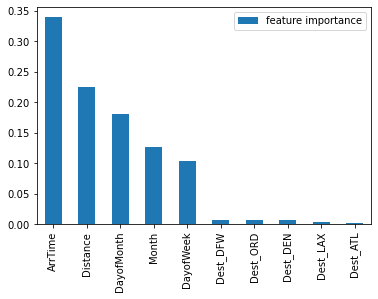

In [13]:
df_feat.plot(kind='bar', );

Arrival Time and Distance have the most weight possibly because they are continuous variables and have more magnitudes than other features.

In [14]:
dtc_pred_train = dtc.predict(scaler_X_train)

In [15]:
print(classification_report(y_train, dtc_pred_train, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       1.00      1.00      1.00     44183
       Delay       1.00      1.00      1.00     90231

    accuracy                           1.00    134414
   macro avg       1.00      1.00      1.00    134414
weighted avg       1.00      1.00      1.00    134414



In [16]:
print('Mean Absolute Error:', mean_absolute_error(y_train, dtc_pred_train))
print('Mean Squared Error:', mean_squared_error(y_train, dtc_pred_train))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, dtc_pred_train)))

Mean Absolute Error: 0.0002380704390911661
Mean Squared Error: 0.0002380704390911661
Root Mean Squared Error: 0.015429531395708882


##### Random Forest

The next model is random forest. This model is creating multiple decision trees in order to find the best prediciton model.

Random Forest Classifier will use different samples to create many decision trees in order to determine the best classificaiton method. 

In [17]:
rfc = RandomForestClassifier()
rfc.fit(scaler_X_train, y_train)

RandomForestClassifier()

##### Feature Importance 

In [18]:
df_feat = pd.DataFrame(rfc.feature_importances_, index=df_col, columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feat

,feature importance
ArrTime,0.410595
Distance,0.263577
DayofMonth,0.152022
Month,0.085325
DayofWeek,0.071635
Dest_ORD,0.005041
Dest_DFW,0.003922
Dest_DEN,0.003259
Dest_LAX,0.003197
Dest_ATL,0.001428


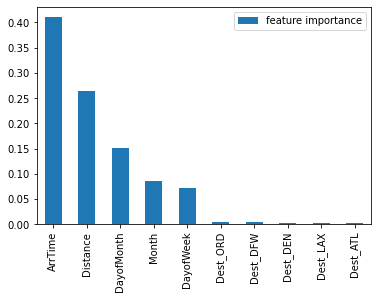

In [19]:
df_feat.plot(kind='bar');

Again, Arrival Time and distance are weighted more in this model. 

In [20]:
rfc_pred_train = rfc.predict(scaler_X_train)

In [21]:
print(classification_report(y_train, rfc_pred_train, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       1.00      1.00      1.00     44183
       Delay       1.00      1.00      1.00     90231

    accuracy                           1.00    134414
   macro avg       1.00      1.00      1.00    134414
weighted avg       1.00      1.00      1.00    134414



In [22]:
print('Mean Absolute Error:', mean_absolute_error(y_train, rfc_pred_train))
print('Mean Squared Error:', mean_squared_error(y_train, rfc_pred_train))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, rfc_pred_train)))

Mean Absolute Error: 0.00024551014031276504
Mean Squared Error: 0.00024551014031276504
Root Mean Squared Error: 0.015668763203034407


##### XGBoost

XGBoost will create decision trees to determine a features weight then adjust weight based on each previous models error. Each predictor is trained using the residual errors of predecessor as labels.

In [23]:
xgbc = XGBClassifier(eval_metric='logloss')

In [24]:
xgbc.fit(scaler_X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

##### Feature Importance 

In [25]:
df_feat = pd.DataFrame(xgbc.feature_importances_, index=df_col, columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feat

,feature importance
Dest_ORD,0.244758
ArrTime,0.133344
Dest_DEN,0.105455
Dest_LAX,0.091589
Distance,0.082504
Dest_DFW,0.081158
Month,0.075802
DayofWeek,0.068360
DayofMonth,0.068198
Dest_ATL,0.048833


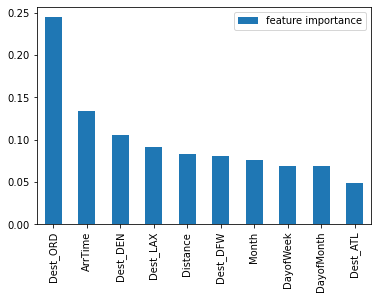

In [26]:
df_feat.plot(kind='bar');

XGBoost weighs each feature more evenly, particularly the destinations weighing more than in previous models. 

In [27]:
xgbc_pred_train = xgbc.predict(scaler_X_train)

In [28]:
print(classification_report(y_train, xgbc_pred_train, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       0.71      0.20      0.31     44183
       Delay       0.71      0.96      0.82     90231

    accuracy                           0.71    134414
   macro avg       0.71      0.58      0.56    134414
weighted avg       0.71      0.71      0.65    134414



In [29]:
print('Mean Absolute Error:', mean_absolute_error(y_train, xgbc_pred_train))
print('Mean Squared Error:', mean_squared_error(y_train, xgbc_pred_train))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, xgbc_pred_train)))

Mean Absolute Error: 0.2898953978008243
Mean Squared Error: 0.2898953978008243
Root Mean Squared Error: 0.5384193512503282


#### Baseline Testing Models

##### Decision Tree

In [30]:
dtc_pred_test = dtc.predict(scaler_X_test)

In [31]:
print(classification_report(y_test, dtc_pred_test, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       0.44      0.46      0.45     10983
       Delay       0.73      0.72      0.73     22621

    accuracy                           0.64     33604
   macro avg       0.59      0.59      0.59     33604
weighted avg       0.64      0.64      0.64     33604



The baseline decision tree model captures the delay, 72% of the predicted delays, are actually delays. And of the delays, 71% are predicted.

In [32]:
print('Mean Absolute Error:', mean_absolute_error(y_test, dtc_pred_test))
print('Mean Squared Error:', mean_squared_error(y_test, dtc_pred_test))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, dtc_pred_test)))

Mean Absolute Error: 0.36483751934293535
Mean Squared Error: 0.36483751934293535
Root Mean Squared Error: 0.6040178137629182


##### Random Forest

In [33]:
rfc_pred_test = rfc.predict(scaler_X_test)

In [34]:
print(classification_report(y_test, rfc_pred_test, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       0.48      0.30      0.37     10983
       Delay       0.71      0.84      0.77     22621

    accuracy                           0.66     33604
   macro avg       0.59      0.57      0.57     33604
weighted avg       0.64      0.66      0.64     33604



The baseline decision tree model captures the dela,y 71% of the predicted delays, are actually delays. And of the delays, 82% are predicted. The model was able to increase its recall because of its use of many decision trees to predict, therefore able to find more scenarios predicting delay.

In [35]:
print('Mean Absolute Error:', mean_absolute_error(y_test, rfc_pred_test))
print('Mean Squared Error:', mean_squared_error(y_test, rfc_pred_test))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, rfc_pred_test)))

Mean Absolute Error: 0.3370729675038686
Mean Squared Error: 0.3370729675038686
Root Mean Squared Error: 0.5805798545453231


##### XGBoost

In [36]:
xgbc_pred_test = xgbc.predict(scaler_X_test)

In [37]:
print(classification_report(y_test, xgbc_pred_test, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       0.58      0.16      0.24     10983
       Delay       0.70      0.94      0.80     22621

    accuracy                           0.69     33604
   macro avg       0.64      0.55      0.52     33604
weighted avg       0.66      0.69      0.62     33604



The baseline decision tree model captures the dela,y 69% of the predicted delays, are actually delays. And of the delays, 93% are predicted. 

In [38]:
print('Mean Absolute Error:', mean_absolute_error(y_test, xgbc_pred_test))
print('Mean Squared Error:', mean_squared_error(y_test, xgbc_pred_test))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, xgbc_pred_test)))

Mean Absolute Error: 0.3132960361861683
Mean Squared Error: 0.3132960361861683
Root Mean Squared Error: 0.5597285379415349


#### Confusion Matrix

##### Decision Tree

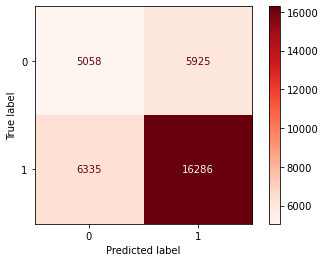

In [39]:
plot_confusion_matrix(dtc, scaler_X_test, y_test,
                      cmap=plt.cm.Reds)
plt.show()

##### Random Forest

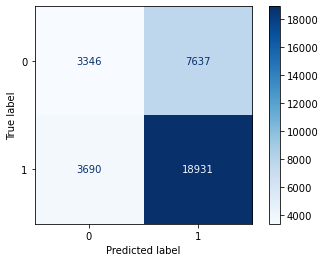

In [40]:
plot_confusion_matrix(rfc, scaler_X_test, y_test,
                      cmap=plt.cm.Blues)
plt.show()

##### XGBoost

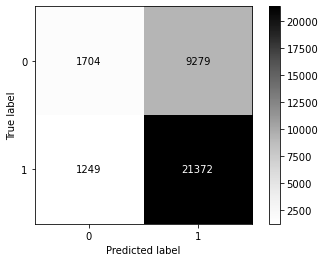

In [41]:
plot_confusion_matrix(xgbc, scaler_X_test, y_test,
                      cmap=plt.cm.Greys)
plt.show()

### Random Search

Random Search will use all the combinations of hyperparameters to determine the best combination for the most accurate sample splits.

##### Parameter Grid

In [42]:
param_grid={
    'criterion':['gini', 'entropy'],
    'random_state': [1,20, 42, 100 ],
    'max_depth':[5,10,20,30,40,50,60,70],
    'min_samples_split':[5,10,20,25,30,40,50],
    'min_samples_leaf':[1,100,200,300,400,500]
}

#### Random Search Training Models

##### Decision Tree

In [43]:
dtc_rand_search = RandomizedSearchCV(dtc, param_grid)

In [44]:
dtc_rand_search.fit(scaler_X_train, y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 20, 30, 40, 50, 60,
                                                      70],
                                        'min_samples_leaf': [1, 100, 200, 300,
                                                             400, 500],
                                        'min_samples_split': [5, 10, 20, 25, 30,
                                                              40, 50],
                                        'random_state': [1, 20, 42, 100]})

In [45]:
dtc_rand_search.best_params_

{'random_state': 42,
 'min_samples_split': 25,
 'min_samples_leaf': 200,
 'max_depth': 10,
 'criterion': 'entropy'}

In [46]:
dtc_rs_pred_train = dtc_rand_search.predict(scaler_X_train)

In [47]:
print(classification_report(y_train, dtc_rs_pred_train, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       0.56      0.12      0.20     44183
       Delay       0.69      0.95      0.80     90231

    accuracy                           0.68    134414
   macro avg       0.63      0.54      0.50    134414
weighted avg       0.65      0.68      0.60    134414



In [48]:
print('Mean Absolute Error:', mean_absolute_error(y_train, dtc_rs_pred_train))
print('Mean Squared Error:', mean_squared_error(y_train, dtc_rs_pred_train))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, dtc_rs_pred_train)))

Mean Absolute Error: 0.31996667013852725
Mean Squared Error: 0.31996667013852725
Root Mean Squared Error: 0.5656559644682687


##### Random Forest

In [49]:
rfc_rand_search = RandomizedSearchCV(rfc, param_grid)

In [50]:
rfc_rand_search.fit(scaler_X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 20, 30, 40, 50, 60,
                                                      70],
                                        'min_samples_leaf': [1, 100, 200, 300,
                                                             400, 500],
                                        'min_samples_split': [5, 10, 20, 25, 30,
                                                              40, 50],
                                        'random_state': [1, 20, 42, 100]})

In [51]:
rfc_rand_search.best_params_

{'random_state': 42,
 'min_samples_split': 30,
 'min_samples_leaf': 100,
 'max_depth': 40,
 'criterion': 'gini'}

In [52]:
rfc_rs_pred_train = rfc_rand_search.predict(scaler_X_train)

In [53]:
print(classification_report(y_train, rfc_rs_pred_train, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       0.71      0.03      0.06     44183
       Delay       0.68      0.99      0.81     90231

    accuracy                           0.68    134414
   macro avg       0.69      0.51      0.43    134414
weighted avg       0.69      0.68      0.56    134414



In [54]:
print('Mean Absolute Error:', mean_absolute_error(y_train, rfc_rs_pred_train))
print('Mean Squared Error:', mean_squared_error(y_train, rfc_rs_pred_train))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, rfc_rs_pred_train)))

Mean Absolute Error: 0.3225854449685301
Mean Squared Error: 0.3225854449685301
Root Mean Squared Error: 0.5679660596976989


##### XGBoost

In [55]:
xgb_param_grid={
    'learning_rate': [0.1, 0.2, 0.3, 0.4],
    'gamma': [0, 1, 2, 3],
    'max_depth': [20,60],
    'min_child_weight': [1, 2],
    'subsample': [0.2, 0.5, 0.7, 0.9],
}

In [56]:
xgb_rand_search = RandomizedSearchCV(xgbc, xgb_param_grid)

In [57]:
xgb_rand_search.fit(scaler_X_train, y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric='logloss', gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints='()',
                                           n_estimators=100, n_jobs=4,
                                           num_parallel_tree=1, random_state=0,
                                           reg_alpha=0, reg_lambda=1

In [58]:
xgb_rs_pred_train = xgb_rand_search.predict(scaler_X_train)

In [59]:
print(classification_report(y_train, xgb_rs_pred_train, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       1.00      0.99      1.00     44183
       Delay       1.00      1.00      1.00     90231

    accuracy                           1.00    134414
   macro avg       1.00      1.00      1.00    134414
weighted avg       1.00      1.00      1.00    134414



In [60]:
print('Mean Absolute Error:', mean_absolute_error(y_train, xgb_rs_pred_train))
print('Mean Squared Error:', mean_squared_error(y_train, xgb_rs_pred_train))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, xgb_rs_pred_train)))

Mean Absolute Error: 0.002633654232446025
Mean Squared Error: 0.002633654232446025
Root Mean Squared Error: 0.05131914099481815


#### Random Search Testing Models

##### Decision Tree

In [61]:
dtc_rs_pred_test = dtc_rand_search.predict(scaler_X_test)

In [62]:
print(classification_report(y_test, dtc_rs_pred_test, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       0.52      0.11      0.18     10983
       Delay       0.69      0.95      0.80     22621

    accuracy                           0.68     33604
   macro avg       0.60      0.53      0.49     33604
weighted avg       0.63      0.68      0.60     33604



In [63]:
print('Mean Absolute Error:', mean_absolute_error(y_test, dtc_rs_pred_test))
print('Mean Squared Error:', mean_squared_error(y_test, dtc_rs_pred_test))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, dtc_rs_pred_test)))

Mean Absolute Error: 0.32418759671467684
Mean Squared Error: 0.32418759671467684
Root Mean Squared Error: 0.5693747419008652


##### Random Forest

In [64]:
rfc_rs_pred_test = rfc_rand_search.predict(scaler_X_test)

In [65]:
print(classification_report(y_test, rfc_rs_pred_test, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       0.62      0.03      0.05     10983
       Delay       0.68      0.99      0.81     22621

    accuracy                           0.68     33604
   macro avg       0.65      0.51      0.43     33604
weighted avg       0.66      0.68      0.56     33604



In [66]:
print('Mean Absolute Error:', mean_absolute_error(y_test, rfc_rs_pred_test))
print('Mean Squared Error:', mean_squared_error(y_test, rfc_rs_pred_test))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, rfc_rs_pred_test)))

Mean Absolute Error: 0.3234733960242828
Mean Squared Error: 0.3234733960242828
Root Mean Squared Error: 0.5687472162782714


##### XGBoost

In [67]:
xgb_rs_pred_test = xgb_rand_search.predict(scaler_X_test)

In [68]:
print(classification_report(y_test, xgb_rs_pred_test, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       0.54      0.39      0.45     10983
       Delay       0.74      0.84      0.79     22621

    accuracy                           0.69     33604
   macro avg       0.64      0.61      0.62     33604
weighted avg       0.67      0.69      0.68     33604



In [69]:
print('Mean Absolute Error:', mean_absolute_error(y_test, xgb_rs_pred_test))
print('Mean Squared Error:', mean_squared_error(y_test, xgb_rs_pred_test))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, xgb_rs_pred_test)))

Mean Absolute Error: 0.3074633972146173
Mean Squared Error: 0.3074633972146173
Root Mean Squared Error: 0.5544938207181549


For our decision tree and random forest recall increased from our baseline and XGBoost generally stayed the same.

#### Confusion Matrix

##### Decision Tree

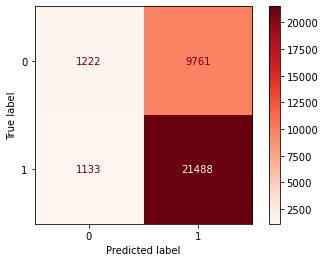

In [70]:
plot_confusion_matrix(dtc_rand_search, scaler_X_test, y_test,
                      cmap=plt.cm.Reds)
plt.show()

##### Random Forest

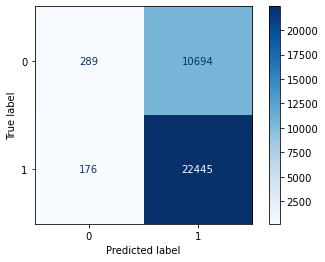

In [71]:
plot_confusion_matrix(rfc_rand_search, scaler_X_test, y_test,
                      cmap=plt.cm.Blues)
plt.show()

##### XGBoost

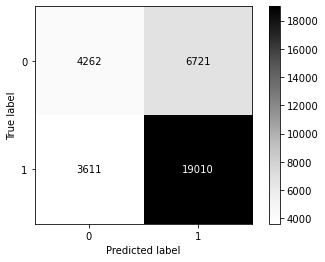

In [72]:
plot_confusion_matrix(xgb_rand_search, scaler_X_test, y_test,
                      cmap=plt.cm.Greys)
plt.show()

### SMOTE 

Since Delay classification contains more data than our On Time classification. There could possibly be a discrepency when comparing different sized sests. SMOTE helps with this class imbalance, so we are better to assume the classifications affect the results equally. 

SMOTE will provide a more realistic prediction with each classification evenly balanced before calcualting our estimator. 

In [73]:
df['DepDelay'].value_counts()

1    112852
0     55166
Name: DepDelay, dtype: int64

In [74]:
smote = SMOTE()

#### SMOTE Training Models

In [75]:
X_train_resampled, y_train_resampled = smote.fit_resample(scaler_X_train, y_train) 

##### Decision Tree

In [76]:
dtc_rand_search.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 20, 30, 40, 50, 60,
                                                      70],
                                        'min_samples_leaf': [1, 100, 200, 300,
                                                             400, 500],
                                        'min_samples_split': [5, 10, 20, 25, 30,
                                                              40, 50],
                                        'random_state': [1, 20, 42, 100]})

In [77]:
dtc_smote_pred_train = dtc_rand_search.predict(X_train_resampled)

In [78]:
print(classification_report(y_train_resampled, dtc_smote_pred_train, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       0.69      0.65      0.67     90231
       Delay       0.67      0.71      0.69     90231

    accuracy                           0.68    180462
   macro avg       0.68      0.68      0.68    180462
weighted avg       0.68      0.68      0.68    180462



In [79]:
print('Mean Absolute Error:', mean_absolute_error(y_train_resampled, dtc_smote_pred_train))
print('Mean Squared Error:', mean_squared_error(y_train_resampled, dtc_smote_pred_train))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train_resampled, dtc_smote_pred_train)))

Mean Absolute Error: 0.3218239851048974
Mean Squared Error: 0.3218239851048974
Root Mean Squared Error: 0.5672953244165665


##### Random Forest

In [80]:
rfc_rand_search.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 20, 30, 40, 50, 60,
                                                      70],
                                        'min_samples_leaf': [1, 100, 200, 300,
                                                             400, 500],
                                        'min_samples_split': [5, 10, 20, 25, 30,
                                                              40, 50],
                                        'random_state': [1, 20, 42, 100]})

In [81]:
rfc_smote_pred_train = rfc_rand_search.predict(X_train_resampled)

In [82]:
print(classification_report(y_train_resampled, rfc_smote_pred_train, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       0.83      0.83      0.83     90231
       Delay       0.83      0.83      0.83     90231

    accuracy                           0.83    180462
   macro avg       0.83      0.83      0.83    180462
weighted avg       0.83      0.83      0.83    180462



In [83]:
print('Mean Absolute Error:', mean_absolute_error(y_train_resampled, rfc_smote_pred_train))
print('Mean Squared Error:', mean_squared_error(y_train_resampled, rfc_smote_pred_train))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train_resampled, rfc_smote_pred_train)))

Mean Absolute Error: 0.16891090645121964
Mean Squared Error: 0.16891090645121964
Root Mean Squared Error: 0.4109877205601399


##### XGBoost

In [84]:
xgb_rand_search.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric='logloss', gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints='()',
                                           n_estimators=100, n_jobs=4,
                                           num_parallel_tree=1, random_state=0,
                                           reg_alpha=0, reg_lambda=1

In [85]:
xgb_smote_pred_train = xgb_rand_search.predict(X_train_resampled)

In [86]:
print(classification_report(y_train_resampled, xgb_smote_pred_train, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       1.00      1.00      1.00     90231
       Delay       1.00      1.00      1.00     90231

    accuracy                           1.00    180462
   macro avg       1.00      1.00      1.00    180462
weighted avg       1.00      1.00      1.00    180462



In [87]:
print('Mean Absolute Error:', mean_absolute_error(y_train_resampled, xgb_smote_pred_train))
print('Mean Squared Error:', mean_squared_error(y_train_resampled, xgb_smote_pred_train))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train_resampled, xgb_smote_pred_train)))

Mean Absolute Error: 0.002188826456539327
Mean Squared Error: 0.002188826456539327
Root Mean Squared Error: 0.04678489560252675


#### SMOTE Testing Models

##### Decision Tree

In [88]:
dtc_smote_pred_test = dtc_rand_search.predict(scaler_X_test)

In [89]:
print(classification_report(y_test, dtc_smote_pred_test, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       0.44      0.51      0.47     10983
       Delay       0.74      0.68      0.71     22621

    accuracy                           0.62     33604
   macro avg       0.59      0.60      0.59     33604
weighted avg       0.64      0.62      0.63     33604



In [90]:
print('Mean Absolute Error:', mean_absolute_error(y_test, dtc_smote_pred_test))
print('Mean Squared Error:', mean_squared_error(y_test, dtc_smote_pred_test))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, dtc_smote_pred_test)))

Mean Absolute Error: 0.37629448875133914
Mean Squared Error: 0.37629448875133914
Root Mean Squared Error: 0.6134284707700965


##### Random Forest

In [91]:
rfc_smote_pred_test = rfc_rand_search.predict(scaler_X_test)

In [92]:
print(classification_report(y_test, rfc_smote_pred_test, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       0.47      0.51      0.49     10983
       Delay       0.75      0.72      0.74     22621

    accuracy                           0.65     33604
   macro avg       0.61      0.61      0.61     33604
weighted avg       0.66      0.65      0.65     33604



In [93]:
print('Mean Absolute Error:', mean_absolute_error(y_test, rfc_smote_pred_test))
print('Mean Squared Error:', mean_squared_error(y_test, rfc_smote_pred_test))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, rfc_smote_pred_test)))

Mean Absolute Error: 0.3488275205332699
Mean Squared Error: 0.3488275205332699
Root Mean Squared Error: 0.5906162210211212


##### XGBoost

In [94]:
xgb_smote_pred_test = xgb_rand_search.predict(scaler_X_test)

In [95]:
print(classification_report(y_test, xgb_smote_pred_test, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       0.53      0.45      0.49     10983
       Delay       0.75      0.80      0.78     22621

    accuracy                           0.69     33604
   macro avg       0.64      0.63      0.63     33604
weighted avg       0.68      0.69      0.68     33604



In [96]:
print('Mean Absolute Error:', mean_absolute_error(y_test, xgb_smote_pred_test))
print('Mean Squared Error:', mean_squared_error(y_test, xgb_smote_pred_test))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, xgb_smote_pred_test)))

Mean Absolute Error: 0.3121949767884776
Mean Squared Error: 0.3121949767884776
Root Mean Squared Error: 0.5587441067147622


With SMOTE our On Time predictions have increased and it closely reflects the Delay's prediciton and recall. 

#### Confusion Matrix

##### Decision Tree

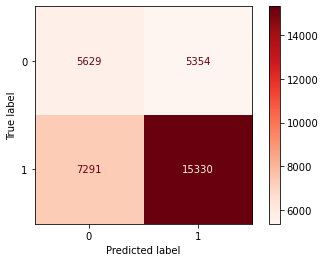

In [97]:
plot_confusion_matrix(dtc_rand_search, scaler_X_test, y_test,
                      cmap=plt.cm.Reds)
plt.show()

##### Random Forest

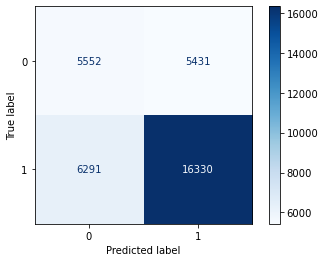

In [98]:
plot_confusion_matrix(rfc_rand_search, scaler_X_test, y_test,
                      cmap=plt.cm.Blues)
plt.show()

##### XGBoost

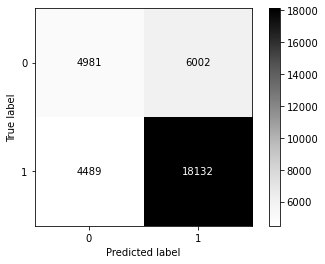

In [99]:
plot_confusion_matrix(xgb_rand_search, scaler_X_test, y_test,
                      cmap=plt.cm.Greys)
plt.show()